# Imports

In [1]:
import csv

import numpy as np
import pandas as pd
import scipy.signal
import astropy.stats

#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# File IO
- J1311 part 1 had error with additional 'E' inserted into line 40

##### Get file paths

In [2]:
file_directory = './data/J1311_photons/'
file_names = ['J1311_phase_part'+str(i)+'.txt' for i in range(1,6)]
print file_names
file_paths = [file_directory + file_name for file_name in file_names]
for file_path in file_paths:
    print file_path

['J1311_phase_part1.txt', 'J1311_phase_part2.txt', 'J1311_phase_part3.txt', 'J1311_phase_part4.txt', 'J1311_phase_part5.txt']
./data/J1311_photons/J1311_phase_part1.txt
./data/J1311_photons/J1311_phase_part2.txt
./data/J1311_photons/J1311_phase_part3.txt
./data/J1311_photons/J1311_phase_part4.txt
./data/J1311_photons/J1311_phase_part5.txt


##### Load pandas df

In [3]:
# Adjust the header to be pandas conformant
fh = open(file_paths[0])
header = ' '.join(fh.read().split('\n')[0].split()).split(' ')
header = [ele.replace('_', ' ') for ele in header]
print header
fh.close()

['ENERGY', 'RA', 'DEC', 'L', 'B', 'THETA', 'PHI', 'TIME', 'EVENT ID', 'PULSE PHASE']


In [4]:
df = pd.read_csv(file_paths[0], skiprows = [0], delimiter = ' ', header = None, names = header)

In [5]:
print df.dtypes

ENERGY         float64
RA             float64
DEC            float64
L              float64
B              float64
THETA          float64
PHI            float64
TIME           float64
EVENT ID         int64
PULSE PHASE    float64
dtype: object


In [6]:
df.head()

,ENERGY,RA,DEC,L,B,THETA,PHI,TIME,EVENT ID,PULSE PHASE
0,117.8400,179.9646,-33.81308,290.8282,27.84342,58.71832,276.24650,2.396096e+08,5314571,0.652637
1,166.4942,179.7794,-36.94781,291.4443,24.75403,17.06174,297.73740,2.396105e+08,7254183,0.695484
2,1414.6280,179.9501,-35.99692,291.3597,25.71173,71.29970,349.51040,2.396118e+08,11024151,0.081871
3,12019.3700,179.7933,-35.63216,291.1318,26.03909,53.59599,75.80354,2.396165e+08,8917657,0.553284
4,176.3304,179.8074,-34.66773,290.9022,26.98145,53.96607,273.46490,2.396555e+08,7993506,0.290104


# Preprocessing

##### Sort in time, set t = 0 first measurement

In [18]:
df = df.sort_values('TIME')
min_time = df['TIME'][0]
df['TIME'] = df['TIME'].map(lambda x: x - min_time)

In [8]:
df.head()

,ENERGY,RA,DEC,L,B,THETA,PHI,TIME,EVENT ID,PULSE PHASE
0,117.8400,179.9646,-33.81308,290.8282,27.84342,58.71832,276.24650,0.0000,5314571,0.652637
1,166.4942,179.7794,-36.94781,291.4443,24.75403,17.06174,297.73740,991.7085,7254183,0.695484
2,1414.6280,179.9501,-35.99692,291.3597,25.71173,71.29970,349.51040,2258.2369,11024151,0.081871
3,12019.3700,179.7933,-35.63216,291.1318,26.03909,53.59599,75.80354,6976.8212,8917657,0.553284
4,176.3304,179.8074,-34.66773,290.9022,26.98145,53.96607,273.46490,45976.5011,7993506,0.290104


##### Inspect columns

In [9]:
df.describe()

,ENERGY,RA,DEC,L,B,THETA,PHI,TIME,EVENT ID,PULSE PHASE
count,3.036117e+06,3.036117e+06,3.036117e+06,3.036117e+06,3.036117e+06,3.036117e+06,3.036117e+06,3.036117e+06,3.036117e+06,3.036117e+06
mean,4.577849e+02,1.980745e+02,-3.672175e+01,3.075376e+02,2.536689e+01,5.544023e+01,1.541910e+02,3.343548e+07,7.433996e+06,4.997797e-01
std,2.385240e+03,9.292467e+00,6.910997e+00,8.317897e+00,6.869596e+00,1.791595e+01,1.140567e+02,1.305799e+07,3.923373e+06,2.888203e-01
min,1.000002e+02,1.796602e+02,-4.948215e+01,2.906225e+02,1.320109e+01,4.602647e-02,1.244711e-04,-4.995458e+04,9.740000e+02,0.000000e+00
25%,1.491545e+02,1.905298e+02,-4.211773e+01,3.008781e+02,1.998093e+01,4.197442e+01,5.434690e+01,2.571877e+07,4.718928e+06,2.495914e-01
50%,2.275397e+02,1.981240e+02,-3.755651e+01,3.075397e+02,2.439697e+01,6.347301e+01,1.346877e+02,3.556251e+07,7.612582e+06,4.996328e-01
75%,4.067823e+02,2.056478e+02,-3.183432e+01,3.141646e+02,3.010335e+01,6.850214e+01,2.635124e+02,4.397708e+07,1.016000e+07,7.498941e-01
max,2.991870e+05,2.162571e+02,-1.948332e+01,3.247774e+02,4.319901e+01,8.410781e+01,3.600000e+02,5.095384e+07,1.790765e+07,9.999995e-01


##### Adjust energy column
Mean photon energy is 457 eV (?), but the max is 299000... That doesn't seem right. Remove all photons that are too far outside of range. Compare the histogram before and after removing these points.

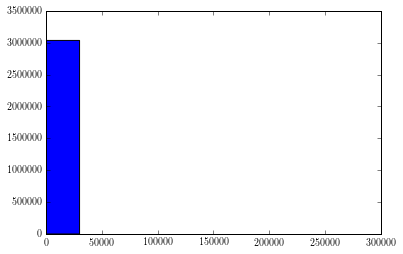

In [10]:
energy = df['ENERGY'].values
plt.hist(energy, bins = 10)
plt.show()

In [11]:
energy_cutoff = np.mean(energy) + 3*np.std(energy)
print energy_cutoff

7613.50314618


In [12]:
print len(df)
df = df[df['ENERGY'] < energy_cutoff]
print len(df)

3036117
3027379


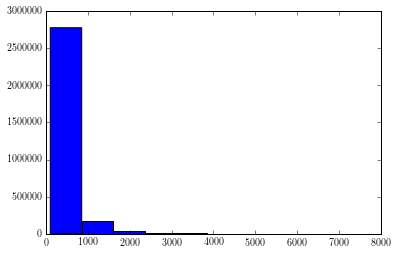

In [13]:
energy = df['ENERGY'].values
plt.hist(energy, bins = 10)
plt.show()

In [14]:
df.describe()

,ENERGY,RA,DEC,L,B,THETA,PHI,TIME,EVENT ID,PULSE PHASE
count,3.027379e+06,3.027379e+06,3.027379e+06,3.027379e+06,3.027379e+06,3.027379e+06,3.027379e+06,3.027379e+06,3.027379e+06,3.027379e+06
mean,3.868079e+02,1.980742e+02,-3.672333e+01,3.075372e+02,2.536528e+01,5.546010e+01,1.541610e+02,3.344523e+07,7.435777e+06,4.997744e-01
std,5.230211e+02,9.293026e+00,6.909625e+00,8.318156e+00,6.868197e+00,1.790765e+01,1.140561e+02,1.305187e+07,3.923071e+06,2.888222e-01
min,1.000002e+02,1.796602e+02,-4.948215e+01,2.906225e+02,1.320109e+01,4.602647e-02,1.244711e-04,-4.995458e+04,9.740000e+02,0.000000e+00
25%,1.489802e+02,1.905284e+02,-4.211755e+01,3.008771e+02,1.998094e+01,4.200962e+01,5.432279e+01,2.573948e+07,4.722188e+06,2.495916e-01
50%,2.269374e+02,1.981235e+02,-3.755783e+01,3.075389e+02,2.439574e+01,6.348494e+01,1.346598e+02,3.556282e+07,7.614664e+06,4.996090e-01
75%,4.041227e+02,2.056483e+02,-3.183808e+01,3.141649e+02,3.009964e+01,6.851036e+01,2.634541e+02,4.397718e+07,1.016178e+07,7.498915e-01
max,7.613303e+03,2.162571e+02,-1.948332e+01,3.247774e+02,4.319901e+01,8.410781e+01,3.600000e+02,5.095384e+07,1.790765e+07,9.999995e-01


##### Remove points within +/- $\phi$ ('on-phase' events)

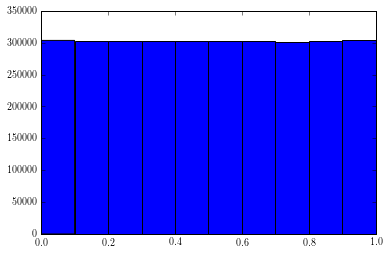

In [15]:
plt.hist(df['PULSE PHASE'])
plt.show()

phase_cutoff = .5
df = df[df['PULSE PHASE'] < phase_cutoff]

# Quick exploration

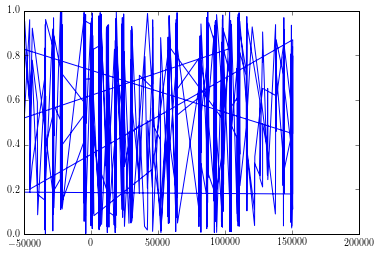

In [17]:
data = df[['TIME', 'PULSE PHASE']].values[:1000]

plt.plot(data[:,0], data[:,1])
plt.show()

##### Check the PSD of the PULSE PHASE to see if we can see the ms pulsar signal

In [54]:
data = df[['TIME', 'PULSE PHASE']].values[:10000]
freq, power = astropy.stats.LombScargle(data[:,0], data[:,1]).autopower(maximum_frequency = 1000)

MemoryError: 

In [51]:
freq = freq*2*3.14159

In [52]:
print np.min(freq), np.max(freq)

4.4535600318e-07 0.111338555439


In [53]:
min_freq = np.min(freq)
duration = 1./min_freq
print duration/(60*60*24)

25.9883643454


In [49]:
print df['TIME'][10000]/(60*60*24)

5.6510553831


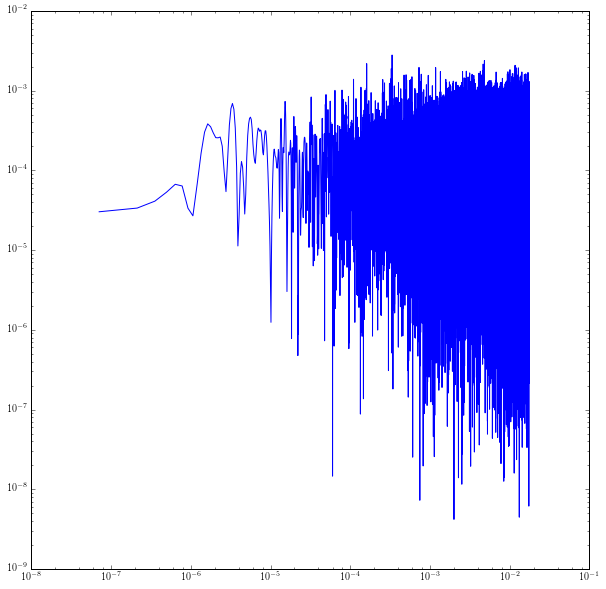

In [44]:
fig = plt.figure(figsize = (10,10))
plt.loglog(freq, power)
plt.show()